# 16 - Pre-Prediction of GoodFit for Static Dataset

This notebook pre-computes GoodFit predictions by systematically varying protected attributes (age, sex, and race). The resulting static dataset enables the frontend to allow users to change one attribute at a time and explore potential bias—without needing to run predictions in real time.

In [110]:
import pandas as pd
import numpy as np
import pickle
import json
import random
import shap

import matplotlib.pyplot as plt

In [111]:
def load_feature_list(feature_list_path: str) -> list:
    """Load the feature list from a JSON file."""
    with open(feature_list_path, "r") as f:
        return json.load(f)

In [112]:
def sample_age(age_range_str: str) -> int:
    """
    Given a string age range (e.g., "20-30", "30-40", etc.),
    sample a random integer within that range. For ">60", sample between 61 and 80.
    """
    if "-" in age_range_str:
        min_age, max_age = map(int, age_range_str.split("-"))
        return random.randint(min_age, max_age)
    elif ">" in age_range_str:
        return random.randint(61, 80)
    else:
        raise ValueError("Invalid age range option.")

In [113]:
def predict_candidate_local(candidate_row: pd.Series, model, feature_list: list) -> dict:
    """Prepare candidate data, run model prediction, and compute top features using SHAP."""
    # Prepare the candidate data.
    prepared_data = candidate_row[feature_list].to_frame().T
    # Ensure all values are numeric.
    prepared_data = prepared_data.apply(pd.to_numeric, errors='coerce')
    
    # Compute the prediction.
    pred_proba = model.predict_proba(prepared_data)[:, 1][0]
    good_fit = pred_proba >= 0.5

    # Compute SHAP values.
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(prepared_data)
    
    # Create a DataFrame with feature importance.
    feature_importance = pd.DataFrame({
        'Feature': prepared_data.columns,
        'SHAP Value': shap_values.values[0]
    }).sort_values(by='SHAP Value', ascending=False)
    
    # Filter out protected features.
    protected_features = {"Age", "Sex"}
    filtered_features = feature_importance[
        ~feature_importance["Feature"].isin(protected_features) &
        ~feature_importance["Feature"].str.startswith("RaceDesc_")
    ]
    
    # Select the top three remaining features.
    top_features = filtered_features.head(3).to_dict(orient="records")
    
    return {
        "prediction_probability": pred_proba,
        "GoodFit": good_fit,
        "top_features": top_features
    }


In [114]:
data_path = "../app/data/static_data.parquet"
out_path="../app/data/static_predictions.parquet"
model_path = "../models/xgb_model.pkl"
features_path = "../models/features.json"

In [115]:
df = pd.read_parquet(data_path)
feature_list = load_feature_list(features_path)
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [116]:
demographic_columns = ['Sex', 'RaceDesc_White', 'RaceDesc_Black or African American', 'RaceDesc_Asian', 'Age']

# For Gender, we assume 0 = Female and 1 = Male.
genders = ["Male", "Female"]
gender_map = {"Female": 0, "Male": 1}
age_options = ["20-30", "30-40", "40-50", "50-60", ">60"]

# For Race, we assume that only one of the three RaceDesc columns is set to 1.
race_options = ["White", "Black", "Asian"]

In [117]:
# ----- Precompute Predictions (Flat Structure) -----
results = []  # This list will collect one row per modification per candidate

for idx, row in df.iterrows():
    candidate_id = row["Candidate_ID"]
    
    # Compute and store the original prediction.
    original_pred = predict_candidate_local(row, model, feature_list)
    results.append({
        "Candidate_ID": candidate_id,
        "Modified_Attribute": None,
        "Original_Value": None,
        "New_Value": None,
        "Prediction_Probability": original_pred["prediction_probability"],
        "GoodFit": original_pred["GoodFit"],
        "Top_Features": original_pred["top_features"],
        "Original_Race_Column": None,
        "New_Race_Column": None
    })
    
    # --- Gender Modification ---
    # For gender, if candidate is Female (0) then produce row for Male; if Male (1) produce row for Female.
    current_gender = row["Sex"]
    for gender in genders:
        if gender_map[gender] == current_gender:
            continue  # Skip if candidate already has this gender
        modified = row.copy()
        modified["Sex"] = gender_map[gender]
        gender_pred = predict_candidate_local(modified, model, feature_list)
        results.append({
            "Candidate_ID": candidate_id,
            "Modified_Attribute": "Sex",
            "Original_Value": "Female" if current_gender == 0 else "Male",
            "New_Value": gender,
            "Prediction_Probability": gender_pred["prediction_probability"],
            "GoodFit": gender_pred["GoodFit"],
            "Top_Features": gender_pred["top_features"],
            "Original_Race_Column": None,
            "New_Race_Column": None
        })
    
    # --- Age Modification ---
    original_age = row["Age"]
    # Convert original numeric age to an age group.
    if original_age < 30:
        original_age_group = "20-30"
    elif original_age < 40:
        original_age_group = "30-40"
    elif original_age < 50:
        original_age_group = "40-50"
    elif original_age < 60:
        original_age_group = "50-60"
    else:
        original_age_group = ">60"
    
    # Iterate over only the age options that differ from the candidate's original age group.
    for age_option in [option for option in age_options if option != original_age_group]:
        modified = row.copy()
        new_age = sample_age(age_option)  # Use this numeric age for the prediction
        modified["Age"] = new_age
        # (Optional) You can update the AgeGroup column if your model uses it;
        # here we leave it as is since the prediction is based on the numeric Age.
        age_pred = predict_candidate_local(modified, model, feature_list)
        results.append({
            "Candidate_ID": candidate_id,
            "Modified_Attribute": "Age",
            "Original_Value": original_age_group,   # Save the original age group
            "New_Value": age_option,                # Save the new age range option
            "Prediction_Probability": age_pred["prediction_probability"],
            "GoodFit": age_pred["GoodFit"],
            "Top_Features": age_pred["top_features"],
            "Original_Race_Column": None,
            "New_Race_Column": None
        })
    
    # --- Race Modification ---
    race_results = {}
    # Determine original race based on the binary indicators.
    if row["RaceDesc_White"] == 1:
        original_race = "White"
        original_race_column = "RaceDesc_White"
    elif row["RaceDesc_Black or African American"] == 1:
        original_race = "Black"
        original_race_column = "RaceDesc_Black or African American"
    elif row["RaceDesc_Asian"] == 1:
        original_race = "Asian"
        original_race_column = "RaceDesc_Asian"
    else:
        original_race = "Unknown"
        original_race_column = None
    
    for race in race_options:
        # Skip if the race is the same as the original.
        if race == original_race:
            continue
        modified = row.copy()
        # Set all race columns to 0, then update the chosen race column to 1.
        modified["RaceDesc_White"] = 0
        modified["RaceDesc_Black or African American"] = 0
        modified["RaceDesc_Asian"] = 0
        new_race_column = None
        if race == "White":
            modified["RaceDesc_White"] = 1
            new_race_column = "RaceDesc_White"
        elif race == "Black":
            modified["RaceDesc_Black or African American"] = 1
            new_race_column = "RaceDesc_Black or African American"
        elif race == "Asian":
            modified["RaceDesc_Asian"] = 1
            new_race_column = "RaceDesc_Asian"
        race_pred = predict_candidate_local(modified, model, feature_list)
        results.append({
            "Candidate_ID": candidate_id,
            "Modified_Attribute": "Race",
            "Original_Value": original_race,
            "New_Value": race,
            "Prediction_Probability": race_pred["prediction_probability"],
            "GoodFit": race_pred["GoodFit"],
            "Top_Features": race_pred["top_features"],
            "Original_Race_Column": original_race_column,
            "New_Race_Column": new_race_column
        })

results_df = pd.DataFrame(results)

In [118]:
results_df[results_df["Candidate_ID"] == 243]

,Candidate_ID,Modified_Attribute,Original_Value,New_Value,Prediction_Probability,GoodFit,Top_Features,Original_Race_Column,New_Race_Column
752,243,None,None,None,0.998521,True,"[{'Feature': 'Basic Machinery Maintenance', 'S...",None,None
753,243,Sex,Female,Male,0.997048,True,"[{'Feature': 'Basic Machinery Maintenance', 'S...",None,None
754,243,Age,40-50,20-30,0.997143,True,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
755,243,Age,40-50,30-40,0.997143,True,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
756,243,Age,40-50,50-60,0.673363,True,"[{'Feature': 'Basic Machinery Maintenance', 'S...",None,None
757,243,Age,40-50,>60,0.999986,True,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
758,243,Race,White,Black,0.999988,True,"[{'Feature': 'Basic Machinery Maintenance', 'S...",RaceDesc_White,RaceDesc_Black or African American
759,243,Race,White,Asian,0.999926,True,"[{'Feature': 'Basic Machinery Maintenance', 'S...",RaceDesc_White,RaceDesc_Asian


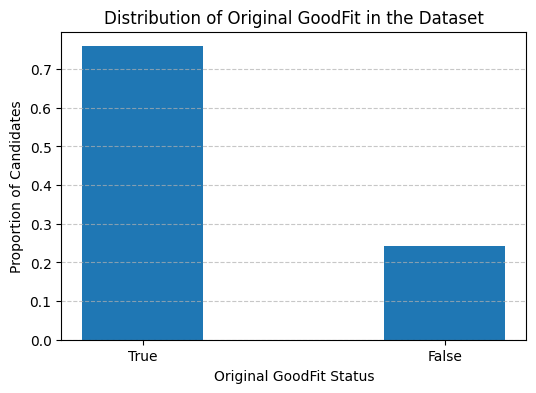

In [119]:
# ----- Visualization Example: Distribution of Original GoodFit -----
goodfit_distribution = results_df["GoodFit"].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
plt.bar(goodfit_distribution.index.astype(str), goodfit_distribution.values, width=0.4)
plt.xlabel("Original GoodFit Status")
plt.ylabel("Proportion of Candidates")
plt.title("Distribution of Original GoodFit in the Dataset")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [120]:
static_data = df.copy()

In [121]:
static_predictions = results_df.copy()

In [122]:
# Get the unique candidate IDs from each dataframe
ids_data = set(static_data["Candidate_ID"].unique())
ids_predictions = set(static_predictions["Candidate_ID"].unique())

# Check if they are the same and print the differences if any
if ids_data == ids_predictions:
    print("Both dataframes contain the same candidate IDs.")
else:
    print("Candidate IDs differ between the two dataframes.")
    print("IDs in static_data but not in static_predictions:", ids_data - ids_predictions)
    print("IDs in static_predictions but not in static_data:", ids_predictions - ids_data)

Both dataframes contain the same candidate IDs.


In [123]:
static_data.head()

,Candidate_ID,Position_IT Support,Position_Production Technician I,Position_Area Sales Manager,Position_Production Manager,Position_Production Technician II,Position_Sales Manager,Position_Enterprise Architect,Position_Network Engineer,Position_Sr. Network Engineer,...,Six Sigma Black Belt,Six Sigma Green Belt,TOGAF Certified,Tableau Desktop Certified Professional,Tableau Desktop Specialist,Employee_Name,Birthplace,Role,Technical_Skills,Certifications_Score
0,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,"Kramer, Kason",UK,Production Technician I,4.0,5.0
1,6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,"Wolfe, Shaniya",Canada,Production Technician I,3.0,0.0
2,7,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,"Jackson, Maryellen",USA,Production Technician I,5.0,0.0
3,9,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,"Mcconnell, Fernando",USA,Production Technician I,3.0,5.0
4,10,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,"Sanders, Taylor",Canada,Production Technician I,4.0,5.0


In [124]:
static_predictions.head(8)

,Candidate_ID,Modified_Attribute,Original_Value,New_Value,Prediction_Probability,GoodFit,Top_Features,Original_Race_Column,New_Race_Column
0,3,None,None,None,0.014106,False,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
1,3,Sex,Male,Female,0.024840,False,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
2,3,Age,>60,20-30,0.999973,True,"[{'Feature': 'YearsExperience', 'SHAP Value': ...",None,None
3,3,Age,>60,30-40,0.999927,True,"[{'Feature': 'YearsExperience', 'SHAP Value': ...",None,None
4,3,Age,>60,40-50,0.991812,True,"[{'Feature': 'YearsExperience', 'SHAP Value': ...",None,None
5,3,Age,>60,50-60,0.955503,True,"[{'Feature': 'Basic Safety Certification', 'SH...",None,None
6,3,Race,White,Black,0.001243,False,"[{'Feature': 'Problem Identification', 'SHAP V...",RaceDesc_White,RaceDesc_Black or African American
7,3,Race,White,Asian,0.074494,False,"[{'Feature': 'Problem Identification', 'SHAP V...",RaceDesc_White,RaceDesc_Asian


In [125]:
def has_goodfit_change(group):
    # Get the original row(s): those where Modified_Attribute is missing
    original_rows = group[group["Modified_Attribute"].isna()]
    if original_rows.empty:
        return False
    # Use the first original row (there should be only one per candidate)
    original_goodfit = original_rows.iloc[0]["GoodFit"]
    # Get all modification rows (Modified_Attribute is not missing)
    modification_rows = group[group["Modified_Attribute"].notna()]
    # Check if any modification has a GoodFit different from the original.
    return any(modification_rows["GoodFit"] != original_goodfit)

In [128]:
def has_at_least_two_each(group):
    """Return True if the candidate group has at least two predictions with GoodFit True and two with GoodFit False."""
    count_true = (group["GoodFit"] == True).sum()
    count_false = (group["GoodFit"] == False).sum()
    return count_true >= 2 and count_false >= 2

# Filter the static_predictions dataframe to include only candidate groups that meet the criterion.
filtered_candidates = results_df.groupby("Candidate_ID").filter(has_at_least_two_each)
display(filtered_candidates.head())

# (Optional) Display the number of candidates that meet the criterion.
print("Number of Candidate IDs with at least two True and two False GoodFit predictions:",
      filtered_candidates["Candidate_ID"].nunique())

,Candidate_ID,Modified_Attribute,Original_Value,New_Value,Prediction_Probability,GoodFit,Top_Features,Original_Race_Column,New_Race_Column
0,3,None,None,None,0.014106,False,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
1,3,Sex,Male,Female,0.024840,False,"[{'Feature': 'Problem Identification', 'SHAP V...",None,None
2,3,Age,>60,20-30,0.999973,True,"[{'Feature': 'YearsExperience', 'SHAP Value': ...",None,None
3,3,Age,>60,30-40,0.999927,True,"[{'Feature': 'YearsExperience', 'SHAP Value': ...",None,None
4,3,Age,>60,40-50,0.991812,True,"[{'Feature': 'YearsExperience', 'SHAP Value': ...",None,None


Number of Candidate IDs with at least two True and two False GoodFit predictions: 276


In [127]:
static_data.to_parquet("../app/data/static_data.parquet", index=False)
print("Static dataset saved to ../app/data/static_data.parquet")

filtered_candidates.to_parquet("../app/data/static_predictions.parquet", index=False)
print("Static predictions saved to ../app/data/static_predictions.parquet")

Static dataset saved to ../app/data/static_data.parquet
Static predictions saved to ../app/data/static_predictions.parquet


TODO: Resample this?